Mount drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


imports

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import random

Load Netflix Prize Data

In [3]:
def load_netflix_data(file_paths):
    data = {'user': [], 'item': [], 'label': []}
    for file_path in file_paths:
        with open(file_path, 'r') as file:
            movie_id = None
            for line in file:
                line = line.strip()
                if line.endswith(':'):
                    movie_id = int(line[:-1])
                else:
                    customer_id, rating, _ = line.split(',')
                    data['item'].append(movie_id)
                    data['user'].append(int(customer_id))
                    data['label'].append(int(rating))
    return pd.DataFrame(data)

In [4]:
data_files = [f'drive/MyDrive/netflix/combined_data_{i}.txt' for i in range(1, 5)]
df = load_netflix_data(data_files)

In [5]:
#Examine dataframe
df.head()

,user,item,label
0,1488844,1,3
1,822109,1,5
2,885013,1,4
3,30878,1,4
4,823519,1,3


In [30]:
#Load the metadata from the netflix dataset for 
#972 of the most popular movies
df_meta = pd.read_csv('drive/MyDrive/filtered.csv')

In [31]:
#Examine the dataframe
df_meta.head()

,id,year,title
0,28,2002,Lilo and Stitch
1,30,2003,Something's Gotta Give
2,111,2003,Duplex (Widescreen)
3,143,1997,The Game
4,175,1992,Reservoir Dogs


In [6]:
#Load the movie id of the 972 movies from above
df_movies = pd.read_csv('drive/MyDrive/movie_ids.csv')

In [7]:
#Examine the dataframe
df_movies.head()

,id
0,15124
1,1905
2,5317
3,16377
4,11283


In [8]:
#filter the main df to only include the 972 popular movies
df = df[df['item'].isin(df_movies['id'])]

In [9]:
#View some df info
len(df)

61786811

Separate out the Probe data for testing and the rest of the data for training

In [10]:
def load_probe(file_path):
    """Load `probe.txt` or `qualifying.txt` into a DataFrame."""
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            # Ignore empty or non-data lines
            line = line.strip()
            if line.endswith(':'):  # Skip MovieID lines
                current_movie_id = int(line[:-1])
            else:
                # CustomerID, MovieID
                customer_id = int(line)
                data.append({'item': current_movie_id, 'user': customer_id})
    return pd.DataFrame(data)

In [11]:
probe_path = 'drive/MyDrive/netflix/probe.txt'
probe_df = load_probe(probe_path)

In [12]:
df_test = probe_df.merge(df, on=['item', 'user'], how='inner')

In [13]:
# Perform an anti-join to keep rows in df that are not in df_test
df_train = pd.merge(
    df,
    df_test,
    on=['user', 'item'],
    how='left',
    indicator=True
)

# Keep only rows that are present in df but not in df_test
df_train = df_train[df_train['_merge'] == 'left_only'].drop(columns='_merge')

df_train = df_train.rename(columns={'label_x': 'label'}).drop(columns=['label_y'], errors='ignore')

In [14]:
#Shuffle the training set
df_train = df_train.sample(frac=1).reset_index(drop=True)

In [15]:
#Shuffle the test set
df_test = df_test.sample(frac=1).reset_index(drop=True)

In [16]:
#Examine the train dataframe
df_train.head()

,user,item,label
0,419599,6994,5
1,791026,8806,5
2,2223558,12435,3
3,1657182,17169,3
4,2179559,7779,4


In [17]:
#Examine the test dataframe
df_test.head()

,item,user,label
0,9886,2360906,2
1,4384,1407957,3
2,5239,1441290,5
3,10168,1962900,4
4,5327,2229171,2


In [18]:
#View some info about the data
print("Number of ALL samples:", len(df))
print("Number of train samples:", len(df_train))
print("Number of test samples:    ", len(df_test))

Number of ALL samples: 61786811
Number of train samples: 60966324
Number of test samples:     820487


Normalization

In [19]:
#Find the avg rating
global_avg = df_train['label'].mean()

print("Global average:", global_avg)

Global average: 3.687599190005289


In [20]:
#Find the normalized ratings
df_train['norm_label'] = df_train['label'] - global_avg
df_test['norm_label'] = df_test['label'] - global_avg

In [21]:
#Examine the train df
df_train.head()

,user,item,label,norm_label
0,419599,6994,5,1.312401
1,791026,8806,5,1.312401
2,2223558,12435,3,-0.687599
3,1657182,17169,3,-0.687599
4,2179559,7779,4,0.312401


In [22]:
#Examine the test df
df_test.head()

,item,user,label,norm_label
0,9886,2360906,2,-1.687599
1,4384,1407957,3,-0.687599
2,5239,1441290,5,1.312401
3,10168,1962900,4,0.312401
4,5327,2229171,2,-1.687599


Initialize Sentence Transformer

In [32]:
from sentence_transformers import SentenceTransformer

# Load a pre-trained Sentence-BERT model (e.g., 'all-MiniLM-L6-v2')
trans = SentenceTransformer('all-MiniLM-L6-v2')

#EXAMPLE ENCODING

# Define your movie title
movie_title = "The Godfather"

# Generate the vector representation of the movie title
embedding1 = trans.encode(movie_title)

# Print the resulting vector
print("Vector representation for '{}':".format(movie_title))
print(embedding1)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Vector representation for 'The Godfather':
[-1.22525558e-01  1.13379036e-03 -9.56871510e-02  5.47665954e-02
 -5.75616993e-02  9.95796360e-03  2.26804381e-03 -6.46629650e-03
  1.13943271e-01 -9.04029012e-02  3.21061024e-03 -7.80717889e-03
 -2.27416456e-02  5.50099127e-02 -7.76552707e-02 -2.36641876e-02
  4.54043634e-02  1.03370316e-01  1.42233039e-03 -5.10848202e-02
 -6.73960820e-02 -4.35555801e-02  1.78134702e-02  3.97260934e-02
 -5.55498824e-02  4.17930484e-02  9.38919187e-03  3.35558727e-02
 -1.03179514e-01 -2.71711648e-02  5.71356807e-03 -2.86266976e-03
  1.45187918e-02 -2.87217069e-02 -3.98255773e-02 -1.62328929e-02
 -2.87437364e-02  3.17840986e-02  3.23617570e-02 -1.47265363e-02
 -2.34379210e-02 -5.58700822e-02  4.38151546e-02  1.87276807e-02
  5.98092861e-02 -3.83687690e-02  2.74423677e-02  6.44438565e-02
  6.94286153e-02  3.80465388e-02 -7.27316290e-02  1.58908695e-03
 -9.21262950e-02  3.20974216e-02  1.56176100e-02  3.27833602e-03
  9.53950337e-04 -2.74439319e-03  5.14112078e-0

In [34]:
#Embed each movie title using the sentence transformer
df_meta['embedding'] = df_meta[' title'].apply(lambda x: trans.encode(x))

In [35]:
#Examine the df
df_meta.head()

,id,year,title,embedding
0,28,2002,Lilo and Stitch,"[-0.09704299, -0.003020708, 0.021977313, -0.02..."
1,30,2003,Something's Gotta Give,"[-0.15155403, 0.037268087, 0.0010926351, -0.01..."
2,111,2003,Duplex (Widescreen),"[0.0013657883, -0.015619282, -0.0064112786, -0..."
3,143,1997,The Game,"[-0.061069205, 0.11639346, -0.07802093, -0.003..."
4,175,1992,Reservoir Dogs,"[-0.05328147, -0.01006568, 0.028697925, 0.0233..."


In [36]:
#Calculate PCA embeddings to reduce the size
from sklearn.decomposition import PCA

pca = PCA(n_components=16)

embeddings = df_meta['embedding'].tolist()
pca_embeddings = pca.fit_transform(embeddings)

df_meta['pca_embedding'] = pca_embeddings.tolist()

In [37]:
#Look at the embeddings
pca_embeddings[0]

array([ 0.10606851,  0.1207686 ,  0.06456602,  0.10826117,  0.00840499,
       -0.11008964,  0.04244222, -0.04207847, -0.00058876,  0.09658444,
        0.01396294, -0.09372837, -0.12424767,  0.04486794, -0.00754213,
        0.01322523])

Normalize the year

In [38]:
min_year = df_meta[" year"].min()
max_year = df_meta[" year"].max()

def normalize_year(year, min_year=min_year, max_year=max_year):
    """
    Clamps the given 'year' to [min_year, max_year] and scales it
    to a 0..1 range.
    """
    if year < min_year:
        year = min_year
    elif year > max_year:
        year = max_year
    return (year - min_year) / (max_year - min_year)

df_meta["year_norm"] = df_meta[" year"].apply(lambda y: normalize_year(y))

In [39]:
#Examine the new df
df_meta.head()

,id,year,title,embedding,pca_embedding,year_norm
0,28,2002,Lilo and Stitch,"[-0.09704299, -0.003020708, 0.021977313, -0.02...","[0.10606851067406105, 0.12076859866362596, 0.0...",0.954545
1,30,2003,Something's Gotta Give,"[-0.15155403, 0.037268087, 0.0010926351, -0.01...","[0.2143226636002369, 0.043819871156522895, -0....",0.969697
2,111,2003,Duplex (Widescreen),"[0.0013657883, -0.015619282, -0.0064112786, -0...","[0.019410465427284817, 0.15969658586103244, -0...",0.969697
3,143,1997,The Game,"[-0.061069205, 0.11639346, -0.07802093, -0.003...","[0.08331625822033259, -0.1283595426251761, -0....",0.878788
4,175,1992,Reservoir Dogs,"[-0.05328147, -0.01006568, 0.028697925, 0.0233...","[0.015343424990144156, -0.12828852225575244, 0...",0.803030


Join the metadata df with the training and testing dfs.

In [40]:
df_meta.rename(columns={'id': 'item'}, inplace=True)

In [41]:
df_train = pd.merge(df_train, df_meta[['item', 'pca_embedding', 'year_norm']],
                     on='item', how='left')

In [42]:
df_test = pd.merge(df_test, df_meta[['item', 'pca_embedding', 'year_norm']],
                     on='item', how='left')

In [43]:
#Examine the training df
df_train.head()

,user,item,label,norm_label,pca_embedding,year_norm
0,419599,6994,5,1.312401,"[0.1407415604244326, -0.015341126476622027, -0...",0.924242
1,791026,8806,5,1.312401,"[0.024600137269242088, -0.0006614317028426482,...",0.409091
2,2223558,12435,3,-0.687599,"[-0.21679362094810176, -0.3376770961534922, -0...",0.757576
3,1657182,17169,3,-0.687599,"[0.008542480739436411, 0.06777231859789168, 0....",0.984848
4,2179559,7779,4,0.312401,"[0.1067116861254521, 0.019514095440955143, 0.0...",0.742424


In [46]:
#Examine the testing df
df_test.head()

,item,user,label,norm_label,pca_embedding,year_norm
0,9886,2360906,2,-1.687599,"[-0.37790726338489244, -0.1476248420206681, -0...",0.909091
1,4384,1407957,3,-0.687599,"[-0.39704002681264616, -0.05753804490025139, -...",0.984848
2,5239,1441290,5,1.312401,"[0.11509792978461462, 0.010840146940235704, -0...",1.000000
3,10168,1962900,4,0.312401,"[-0.11218659007256039, 0.12784389217294315, 0....",0.969697
4,5327,2229171,2,-1.687599,"[0.2065629197598968, -0.06095998438563359, 0.2...",1.000000


Get things ready for TF

In [47]:
unique_values = df_train['user'].unique()

print(unique_values)
len(unique_values)

[ 419599  791026 2223558 ... 1891337 1439552 1929032]


476906

In [48]:

# Convert your user, item, and label columns to numpy arrays for TensorFlow
train_user = df_train['user'].values
train_item = df_train['item'].values
train_title = np.stack(df_train['pca_embedding'].values)
train_year = np.stack(df_train['year_norm'].values)
train_label = df_train['norm_label'].values.astype(np.float32)  # ensure float for regression

test_user = df_test['user'].values
test_item = df_test['item'].values
test_tile = np.stack(df_test['pca_embedding'].values)
test_year = np.stack(df_test['year_norm'].values)
test_label = df_test['norm_label'].values.astype(np.float32)

# Let's confirm shapes
print("train_user shape:", train_user.shape)
print("train_item shape:", train_item.shape)
print("train_tile shape:", train_title.shape)
print("train_year shape:", train_year.shape)
print("train_label shape:", train_label.shape)

print("test_user shape:", test_user.shape)
print("test_item shape:", test_item.shape)
print("test_tile shape:", test_tile.shape)
print("test_year shape:", test_year.shape)
print("test_label shape:", test_label.shape)

# Compute maximum user and item IDs (assume IDs start at 1 or 0; add 1 to handle indexing)
max_user_id = np.max(train_user) + 1
max_item_id = np.max(train_item) + 1

print("Max user ID:", max_user_id)
print("Max item ID:", max_item_id)

train_user shape: (60966324,)
train_item shape: (60966324,)
train_tile shape: (60966324, 16)
train_year shape: (60966324,)
train_label shape: (60966324,)
test_user shape: (820487,)
test_item shape: (820487,)
test_tile shape: (820487, 16)
test_year shape: (820487,)
test_label shape: (820487,)
Max user ID: 2649430
Max item ID: 17765


Set hyperparameters

In [49]:
embedding_dim_user = 32
embedding_dim_item = 32

dense_units_user_1 = 32
dense_units_user_2 = 16


dense_units_item_1 = 32
dense_units_item_2 = 16

learning_rate = 0.0003

dropout_rate_user_1 = 0.0
dropout_rate_user_2 = 0.0
dropout_rate_user_3 = 0.0

dropout_rate_item_1 = 0.0
dropout_rate_item_2 = 0.0
dropout_rate_item_3 = 0.0

activation_user_1 = 'tanh'
activation_user_2 = 'tanh'
activation_user_3 = 'tanh'

activation_item_1 = 'tanh'
activation_item_2 = 'tanh'
activation_item_3 = 'tanh'

l2_reg = 0.000

Create the model

In [50]:
# Two input layers
user_input = keras.Input(shape=(), name='user_input', dtype=tf.int32)
item_input = keras.Input(shape=(), name='item_input', dtype=tf.int32)
title_input = keras.Input(shape=(16,), name='title_input', dtype=tf.float32)
year_input = keras.Input(shape=(1,), name='year_input', dtype=tf.float32)

# User tower
user_embedding_layer = layers.Embedding(
    input_dim=max_user_id,
    output_dim=embedding_dim_user,
    name='user_embedding'
)(user_input)
user_vec = layers.Flatten(name='flatten_user')(user_embedding_layer)
user_vec = layers.Dense(dense_units_user_1, activation=activation_user_1, name='user_dense1')(user_vec)
user_vec = layers.Dense(dense_units_user_2, activation=activation_user_2, name='user_dense2')(user_vec)

# Item tower
item_embedding_layer = layers.Embedding(
    input_dim=max_item_id,
    output_dim=embedding_dim_item,
    name='item_embedding'
)(item_input)
item_flat = layers.Flatten(name='flatten_item')(item_embedding_layer)

title_flat = layers.Flatten(name='flatten_title')(title_input)
year_flat = layers.Flatten(name='flatten_year')(year_input)

concat_layer = layers.Concatenate(name='concat_item')([item_flat, title_flat, year_flat])

item_vec = layers.Dense(dense_units_item_1, activation=activation_item_1, name='item_dense1')(concat_layer)
item_vec = layers.Dense(dense_units_item_2, activation=activation_item_2, name='item_dense2')(item_vec)

# Dot product
dot_user_item = layers.Dot(axes=1, normalize=False, name='dot_user_item')([user_vec, item_vec])

# Final output
rating_prediction = layers.Dense(1, activation='linear', name='rating_prediction')(dot_user_item)

In [51]:
print("train_user min =", train_user.min(), "max =", train_user.max())
print("max_user_id =", max_user_id)

print("train_item min =", train_item.min(), "max =", train_item.max())
print("max_item_id =", max_item_id)


train_user min = 6 max = 2649429
max_user_id = 2649430
train_item min = 28 max = 17764
max_item_id = 17765


train the model

In [58]:
model = keras.Model(
    inputs=[user_input, item_input, title_input, year_input],
    outputs=rating_prediction
)

In [59]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ item_input (InputLayer)   │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_input (InputLayer)   │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item_embedding            │ (None, 32)             │        568,480 │ item_input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ title_input (InputLayer)  │ (None, 16)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ year_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_embedding            │ (None, 32)             │     84,781,760 │ user_input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_item (Flatten)    │ (None, 32)             │              0 │ item_embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_title (Flatten)   │ (None, 16)             │              0 │ title_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_year (Flatten)    │ (None, 1)              │              0 │ year_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_user (Flatten)    │ (None, 32)             │              0 │ user_embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concat_item (Concatenate) │ (None, 49)             │              0 │ flatten_item[0][0],    │
│                           │                        │                │ flatten_title[0][0],   │
│                           │                        │                │ flatten_year[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_dense1 (Dense)       │ (None, 32)             │          1,056 │ flatten_user[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item_dense1 (Dense)       │ (None, 32)             │          1,600 │ concat_item[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_dense2 (Dense)       │ (None, 16)             │            528 │ user_dense1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item_dense2 (Dense)       │ (None, 16)             │            528 │ item_dense1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dot_user_item (Dot)       │ (None, 1)              │              0 │ user_dense2[0][0],     │
│                           │                        │                │ item_dense2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rating_prediction (Dense) │ (None, 1)              │              2 │ dot_user_item[0][0]    │
└──────────────────────

 Total params: 85,353,954 (325.60 MB)

 Trainable params: 85,353,954 (325.60 MB)

 Non-trainable params: 0 (0.00 B)

In [60]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=[keras.metrics.RootMeanSquaredError(name='rmse')]
)

print("Model compiled successfully.")

Model compiled successfully.


In [61]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(
    monitor='val_rmse',       # or 'val_loss'
    mode='min',               # we want to minimize RMSE
    patience=2,
    restore_best_weights=True,
    verbose=1
)

In [62]:
print("train_user shape:", train_user.shape)
print("train_item shape:", train_item.shape)
print("train_title shape:", train_title.shape)
print("train_year shape:", train_year.shape)
print("train_label shape:", train_label.shape)

train_user shape: (60966324,)
train_item shape: (60966324,)
train_title shape: (60966324, 16)
train_year shape: (60966324,)
train_label shape: (60966324,)


In [63]:
batch_size = 2048
epochs = 3

history = model.fit(
    x=[train_user, train_item, train_title, train_year],
    y=train_label,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[early_stop],
    validation_split=0.1,  # 10% of training data used for validation
    verbose=1
)

Epoch 1/3
26792/26792 ━━━━━━━━━━━━━━━━━━━━ 143s 5ms/step - loss: 0.8188 - rmse: 0.9044 - val_loss: 0.7076 - val_rmse: 0.8412
Epoch 2/3
26792/26792 ━━━━━━━━━━━━━━━━━━━━ 132s 5ms/step - loss: 0.6680 - rmse: 0.8173 - val_loss: 0.6847 - val_rmse: 0.8275
Epoch 3/3
26792/26792 ━━━━━━━━━━━━━━━━━━━━ 132s 5ms/step - loss: 0.6260 - rmse: 0.7912 - val_loss: 0.6781 - val_rmse: 0.8235
Restoring model weights from the end of the best epoch: 3.


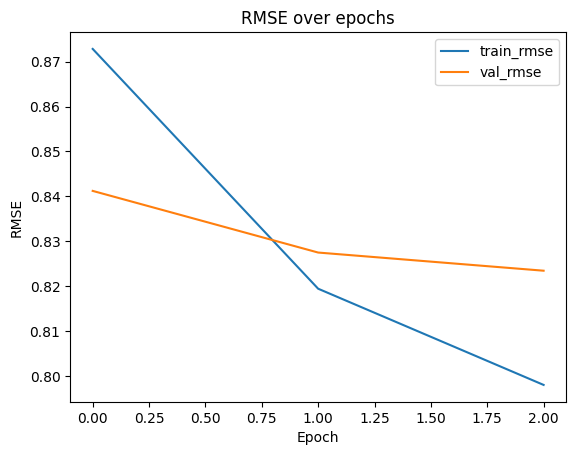

In [64]:
plt.plot(history.history['rmse'], label='train_rmse')
plt.plot(history.history['val_rmse'], label='val_rmse')
plt.title('RMSE over epochs')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

Save the model and embeddings

In [66]:
model.save("drive/MyDrive/gmem.keras")

test the model

In [65]:
predictions = model.predict([test_user, test_item, test_tile, test_year])
mse = np.mean((predictions.flatten() - test_label)**2)
rmse = np.sqrt(mse)
print("RMSE: ", rmse)

25641/25641 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step
RMSE:  0.9182096


Make the embeddings

In [68]:
#Intermediate model that takes in movies and returns the vector right before the dot product
intermediate_model = keras.Model(inputs=model.inputs, outputs=model.get_layer("item_dense2").output)

In [70]:
#Pick 970 random users along with the input info for each movie.
#This wil be plugged into the intermediate model to get embeddings
build_users = train_user[:970]
build_items = df_meta['item'].values
build_titles = np.stack(df_meta['pca_embedding'].values)
build_years = np.stack(df_meta['year_norm'].values)

In [72]:
#Use the intermediate model to generate embeddings for each movie.
movie_embeddings = intermediate_model.predict([build_users, build_items, build_titles, build_years])

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [73]:
#Look at the first embedding
movie_embeddings[0]

array([ 0.02267248, -0.04661905, -0.26499924,  0.00205835, -0.24633868,
        0.16368484,  0.20666814,  0.47025284, -0.42931354, -0.0871766 ,
        0.02801373,  0.72572815, -0.4092375 ,  0.17702504,  0.18131913,
       -0.4846848 ], dtype=float32)

In [75]:
#Stack the embeddings into a 2d array
arr_data = np.vstack(movie_embeddings)
arr_data.shape

(970, 16)

In [76]:
#Turn the 2d array into a df with a column for each of the 16 features in the embedding
df_arr = pd.DataFrame(arr_data, columns=[f"feature_{i}" for i in range(1, 17)])

In [77]:
#Take a look at the df
df_arr

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16
0,0.022672,-0.046619,-0.264999,0.002058,-0.246339,0.163685,0.206668,0.470253,-0.429314,-0.087177,0.028014,0.725728,-0.409238,0.177025,0.181319,-0.484685
1,-0.034511,-0.150917,0.311247,0.553234,0.163956,0.117782,0.586246,-0.057972,-0.485735,-0.100956,0.098881,0.532428,-0.283507,-0.571461,-0.119147,-0.544009
2,-0.373251,0.107183,-0.379379,-0.019213,0.190449,0.074692,0.316270,-0.068675,-0.717374,-0.356092,-0.073990,-0.028135,0.041220,-0.710487,0.593704,-0.705546
3,-0.399297,-0.170430,0.014413,0.882139,-0.588318,0.063229,0.351257,0.009445,-0.456447,0.454165,-0.214734,-0.103632,-0.042765,0.302726,0.089273,-0.540521
4,0.209091,-0.266571,0.010041,0.499381,0.448013,0.728048,-0.077915,0.103958,-0.115441,0.369230,-0.596034,-0.498549,-0.255422,0.615441,0.546417,0.014236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
965,0.096858,0.472940,-0.251432,0.043152,-0.183418,-0.159820,0.594324,0.288818,0.237473,0.027703,-0.344180,0.735708,-0.494132,0.631417,-0.123628,-0.439758
966,-0.260978,0.139461,-0.695949,-0.716574,0.457376,-0.115717,0.125526,-0.015580,-0.489186,-0.421882,-0.041369,0.188164,-0.183041,-0.186893,0.420812,-0.863310
967,0.374409,-0.062499,0.340542,0.824441,0.129980,0.071054,0.164043,0.483334,-0.488178,0.403280,-0.495424,0.334213,-0.072765,-0.021060,-0.157005,-0.397244
968,-0.496976,0.176058,-0.059879,0.905965,-0.308712,0.193948,0.110646,0.281144,-0.255035,0.078165,-0.024952,0.137809,-0.001835,0.307531,-0.129833,-0.569351


In [78]:
#Add the movie id to teh dataframe
df_arr['id'] = build_items

In [79]:
#Look at the dataframe
df_arr

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,id
0,0.022672,-0.046619,-0.264999,0.002058,-0.246339,0.163685,0.206668,0.470253,-0.429314,-0.087177,0.028014,0.725728,-0.409238,0.177025,0.181319,-0.484685,28
1,-0.034511,-0.150917,0.311247,0.553234,0.163956,0.117782,0.586246,-0.057972,-0.485735,-0.100956,0.098881,0.532428,-0.283507,-0.571461,-0.119147,-0.544009,30
2,-0.373251,0.107183,-0.379379,-0.019213,0.190449,0.074692,0.316270,-0.068675,-0.717374,-0.356092,-0.073990,-0.028135,0.041220,-0.710487,0.593704,-0.705546,111
3,-0.399297,-0.170430,0.014413,0.882139,-0.588318,0.063229,0.351257,0.009445,-0.456447,0.454165,-0.214734,-0.103632,-0.042765,0.302726,0.089273,-0.540521,143
4,0.209091,-0.266571,0.010041,0.499381,0.448013,0.728048,-0.077915,0.103958,-0.115441,0.369230,-0.596034,-0.498549,-0.255422,0.615441,0.546417,0.014236,175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
965,0.096858,0.472940,-0.251432,0.043152,-0.183418,-0.159820,0.594324,0.288818,0.237473,0.027703,-0.344180,0.735708,-0.494132,0.631417,-0.123628,-0.439758,17627
966,-0.260978,0.139461,-0.695949,-0.716574,0.457376,-0.115717,0.125526,-0.015580,-0.489186,-0.421882,-0.041369,0.188164,-0.183041,-0.186893,0.420812,-0.863310,17692
967,0.374409,-0.062499,0.340542,0.824441,0.129980,0.071054,0.164043,0.483334,-0.488178,0.403280,-0.495424,0.334213,-0.072765,-0.021060,-0.157005,-0.397244,17709
968,-0.496976,0.176058,-0.059879,0.905965,-0.308712,0.193948,0.110646,0.281144,-0.255035,0.078165,-0.024952,0.137809,-0.001835,0.307531,-0.129833,-0.569351,17762


In [80]:
#Save the dataframe to csv
df_arr.to_csv('drive/MyDrive/movie_embeddings.csv', index=False)